
## Лабораторная работа №1: Фильтр Блума
 
### Задачи:
1. Реализовать фильтр Блума с собственными хеш-функциями
2. Определить процент ложноположительных срабатываний
3. Исследовать зависимость ложноположительных срабатываний от параметров m и k
4. Реализовать операции объединения и пересечения фильтров


### Задание 1: Реализация фильтра Блума

In [63]:
import hashlib
import random
import string
import matplotlib.pyplot as plt

In [64]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m  # Размер битового массива
        self.k = k  # Количество хеш-функций
        self.bit_array = [False] * m  # Инициализируем все биты как False

    def _hash_function(self, item, salt):
        """Кастомная хеш-функция с добавлением соли"""
        salted_item = item + str(salt)  # Добавляем соль для уникальности
        prime = 31  # Простое число для полиномиального хеширования
        hash_val = 0
        for char in salted_item:
            hash_val = hash_val * prime + ord(char)  # Полиномиальная функция
            hash_val %= self.m  # Ограничиваем размер хеша
        return hash_val

    def add(self, item):
        """Добавление элемента в фильтр"""
        for i in range(self.k):
            # Вычисляем хеш для каждой функции (i как соль)
            index = self._hash_function(item, i)
            self.bit_array[index] = True  # Устанавливаем бит

    def check(self, item):
        """Проверка элемента в фильтре"""
        for i in range(self.k):
            index = self._hash_function(item, i)
            if not self.bit_array[index]:
                return False  # Если хотя бы один бит не установлен
        return True  # Все биты установлены (возможен ложноположительный результат)

In [65]:
def generate_non_overlapping_data(base_data, num_items):
    """Генерация данных без пересечений с базовым набором"""
    test_data = set()
    while len(test_data) < num_items:
        item = ''.join(random.choices(string.ascii_lowercase, k=5))
        if item not in base_data:
            test_data.add(item)
    return list(test_data)

def calculate_fp_rate(filter, test_set):
    """Вычисление процента ложных срабатываний"""
    fp = sum(1 for item in test_set if filter.check(item))
    return (fp / len(test_set)) * 100

In [66]:
def run_m_experiment():
    """Эксперимент с изменением размера фильтра (m)"""
    train_data = {''.join(random.choices(string.ascii_lowercase, k=5)) for _ in range(1000)}
    test_data = generate_non_overlapping_data(train_data, 1000)
    
    results = []
    for m in [100, 200, 500, 1000, 2000]:
        bf = BloomFilter(m, 3)
        for item in train_data:
            bf.add(item)
        rate = calculate_fp_rate(bf, test_data)
        results.append(rate)
        print(f"m={m}, FP rate={rate:.2f}%")
    
    plt.plot([100, 200, 500, 1000, 2000], results)
    plt.title('Зависимость FP rate от m')
    plt.show()

def run_k_experiment():
    """Эксперимент с изменением числа хеш-функций (k)"""
    train_data = {''.join(random.choices(string.ascii_lowercase, k=5)) for _ in range(1000)}
    test_data = generate_non_overlapping_data(train_data, 1000)
    
    results = []
    for k in [1, 3, 5, 7, 10]:
        bf = BloomFilter(1000, k)
        for item in train_data:
            bf.add(item)
        rate = calculate_fp_rate(bf, test_data)
        results.append(rate)
        print(f"k={k}, FP rate={rate:.2f}%")
    
    plt.plot([1, 3, 5, 7, 10], results)
    plt.title('Зависимость FP rate от k')
    plt.show()

In [67]:
def bloom_union(bf1, bf2):
    """Объединение двух фильтров Блума"""
    if bf1.m != bf2.m or bf1.k != bf2.k:
        raise ValueError("Несовместимые фильтры")
    
    new_bf = BloomFilter(bf1.m, bf1.k)
    for i in range(bf1.m):
        new_bf.bit_array[i] = bf1.bit_array[i] or bf2.bit_array[i]
    return new_bf

def bloom_intersection(bf1, bf2):
    """Пересечение двух фильтров Блума"""
    if bf1.m != bf2.m or bf1.k != bf2.k:
        raise ValueError("Несовместимые фильтры")
    
    new_bf = BloomFilter(bf1.m, bf1.k)
    for i in range(bf1.m):
        new_bf.bit_array[i] = bf1.bit_array[i] and bf2.bit_array[i]
    return new_bf

Задание 1: Создание фильтра
Проверка 'test': True

Задание 2: Расчет FP rate
FP rate: 1.0%

Задание 3: Эксперименты
m=100, FP rate=100.00%
m=200, FP rate=100.00%
m=500, FP rate=100.00%
m=1000, FP rate=89.40%
m=2000, FP rate=60.90%


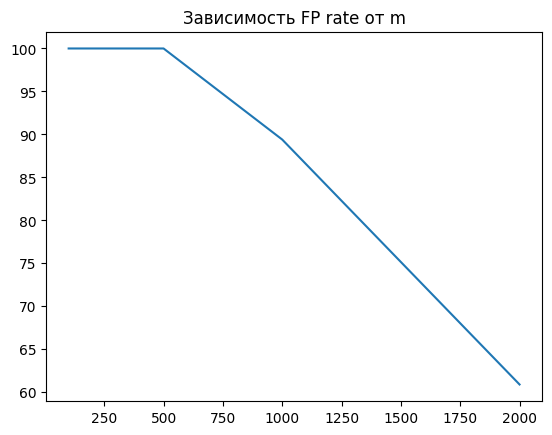

k=1, FP rate=62.00%
k=3, FP rate=87.20%
k=5, FP rate=96.60%
k=7, FP rate=100.00%
k=10, FP rate=100.00%


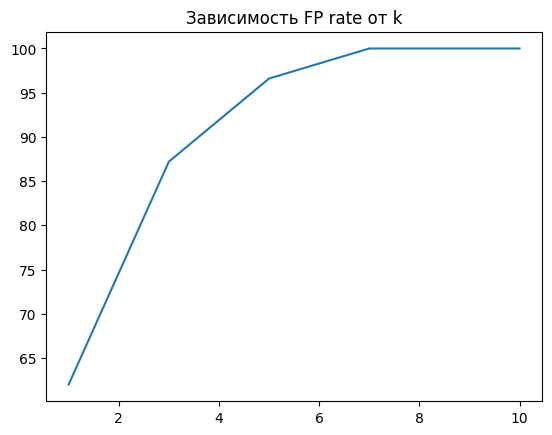


Задание 4: Операции с фильтрами
Объединение содержит 'apple': True
Объединение содержит 'orange': True


In [68]:
if __name__ == "__main__":
    # Демонстрация всех заданий
    print("Задание 1: Создание фильтра")
    bf = BloomFilter(100, 3)
    bf.add("test")
    print("Проверка 'test':", bf.check("test"))
    
    print("\nЗадание 2: Расчет FP rate")
    test_set = generate_non_overlapping_data({"test"}, 100)
    print(f"FP rate: {calculate_fp_rate(bf, test_set):.1f}%")
    
    print("\nЗадание 3: Эксперименты")
    run_m_experiment()
    run_k_experiment()
    
    print("\nЗадание 4: Операции с фильтрами")
    bf1 = BloomFilter(100, 3)
    bf1.add("apple")
    bf2 = BloomFilter(100, 3)
    bf2.add("orange")
    
    united = bloom_union(bf1, bf2)
    print("Объединение содержит 'apple':", united.check("apple"))
    print("Объединение содержит 'orange':", united.check("orange"))